本章中，我们将学习如何利用Python的来实现具有多个隐藏层的图片分类问题。

此外，通过这次建立的多层神经网络模型，可以将之前的猫分类问题的准确率提升到80%。

学习目标：

1. 使用非线性映射单元（例如ReLU）去改善你的模型。

2. 建立一个多个隐藏层的神经网络

3. 创建一个易于调用的模型类

**笔记：**

- 上标 $[l]$ 表示的是第 $l^{th}$ 层神经元. 
    - 例如: $a^{[L]}$ 是第 $L^{th}$ 的激活函数activation. $W^{[L]}$ 和 $b^{[L]}$ 是第 $L^{th}$ 层的参数.
- 上标 $(i)$ 表示的是第 $i^{th}$ 样本. 
    - 例如: $x^{(i)}$ 是第 $i^{th}$ 训练样本.
- 下标 $i$ 表示的是向量里的第 $i^{th}$ 个值.
    - 例如: $a^{[l]}_i$ 表示在第 $l^{th}$ 层激活函数列向量中的第 $i^{th}$ 个激活函数.

In [1]:
# import library

import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
 
np.random.seed(1) #设置seed用来保证每次随机的结果都一致

In [2]:
# 在最后输出层中的神经元中我们将使用sigmoid作为激活函数。
# 在隐藏层中我们使用ReLU函数作为激活函数
# 这里我们提前准备了两种函数的前向和反向推导

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


### 任务描述

接下来，我们首先简单的描述一下我们需要实现的功能。

为了最终建立我们的神经网络模型，我们首先需要实现其中相关的一些方法。这些方法将用在后面的二层模型和多层模型中。

接下来，我们将会去依次实现这些需要的方法。

一个神经网络的计算过程如下:

1. 初始化网络参数 （二层和多层）

2. 处理前向传播

    2.1 完成层中的线性函数部分前向传播，获得 $Z^{[l]}$
    
    2.2 完成激活函数部分的前向传播，组成一个**线性->激活**的前向传播函数

    2.3 计算层中的激活函数部分前向传播（ReLU使用L-1次，从1到L-1层。Sigmod使用1次，L层即输出层），得出一个L_model_forward函数

3. 计算误差

4. 处理反向传播

    4.1 完成线性部分的反向传播公式

    4.2 完成激活函数部分的反向传播公式， 组成一个**线性->激活**的反向传播函数

    4.3 LINEAR->ReLU反向传播L-1次，并把LINEAR->Sigmoid反向传播加到L_model_backword函数中

5. 更新参数，梯度下降

6. 预测函数

整个流程图如下图所示：

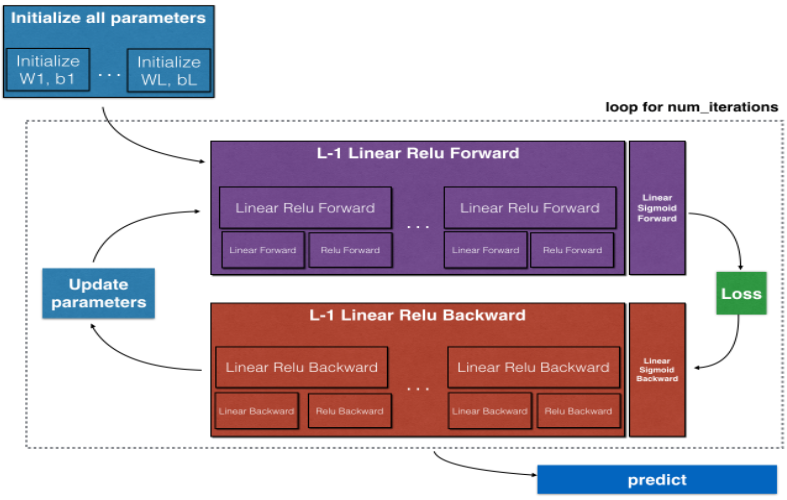

提示：每一个前向传播函数都有一个反向传播函数与之对应。 这就是为什么我们会将前向传播函数放到cache中. 这些被缓存的值对计算梯度十分有用. 在反向传播函数中我们会用他们计算梯度。

In [3]:
# 接下来，我们需要实现初始化函数

# 对于一个两层的神经网络结构而言，模型结构是线性->ReLU->线性->sigmod函数。
# 对 W 使用随机值初始化
# 对 b 初始化为零

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    # 初始化成一个小值
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters  

# 试验一下

parameters = initialize_parameters(2,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.00865408 -0.02301539]]
b2 = [[ 0.]]


那么，对于一个L层的神经网络而言呢？初始化是什么样的？

我们必须注意每一层之间的维度必须正确，回忆一下  $n^{[l]}$  表示多少个单元在层 $l$ 中. 

假设X的维度为（12288,209）

<table style="width:100%">


    <tr>
        <td>  </td> 
        <td> **Shape of W** </td> 
        <td> **Shape of b**  </td> 
        <td> **Activation** </td>
        <td> **Shape of Activation** </td> 
    <tr>
    
    <tr>
        <td> **Layer 1** </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    
    <tr>
        <td> **Layer 2** </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
   
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
    
   <tr>
        <td> **Layer L-1** </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
   <tr>
        <td> **Layer L** </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

第$l$层的W的维度为(layer_dims[$l$], layer_dims[$l$-1])。

而第$l$层的b的维度为(layer_dims[$l$], 1)。

注意当我们再python中计算 $W X + b$ 时, 他会使用广播机制. 比如: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

那么 $WX + b$ 会是:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

**提示**:

- 模型的结构是 *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. 比如 有 $L-1$ 层使用 ReLU 激活函数，紧接着一个输出层使用sigmoid激活函数.
- 对 W 使用随机初始化.  `np.random.rand(shape) * 0.01`.
- 对 b 使用零初始化.  `np.zeros(shape)`.
- 保存不同层中的单元数 $n^{[l]}$ 到一个变量中 `layer_dims`. 比如  `layer_dims` 在上一个浅层网络实验中就是 [2,4,1]: 两个单元在输入层中, 隐藏层中包含4个单元, 输出层中有一个单元. 然后 `W1`'的维度就是 (4,2), `b1` 是 (4,1), `W2` 是 (1,4) `b2` 是 (1,1). 你可以应用规则到 $L$ 层上! 
- 下面是一个在 $L=1$ (单层神经网络)的初始化实现. 那么举一反三实现L层模型的初始化吧
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [4]:
# 初始化函数，L层模型

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        # 注意这里的问题，在深层网络中见效不明显
        # parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


## 前向传播函数

### 线性前向传播

在完成了参数初始化后，我们将完成前向传播函数. 我们先从基础的函数做起，然后把这些函数应用到模型中. 我们想完成三个函数:

- 线性函数
- 线性 -> 激活函数， 这里的激活我们将是 ReLU 或 Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (完成整个模型)

线性前向传播函数 (矢量化) 的公式:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

其中 $A^{[0]} = X$. 

**提示**:

这部分的数学公式是 $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. 你可以使用 `np.dot()`. 如果发现维度不通， 可以打印 `W.shape` 查看.

In [5]:
# 前向传播

# 先计算线性函数部分

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.
 
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
 
    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    # Z = W.dot(A) + b
    ### END CODE HERE ###
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

#测试一下

def linear_forward_test_case():
    np.random.seed(1)
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = np.array([[1]])
    """
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    return A, W, b

A, W, b = linear_forward_test_case()
 
Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


### Linear-Activation前向传播

这里我们使用两种激活函数:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 前面我们定义了 `sigmoid` 函数. 该函数返回 **2** 个值: 激活函数值 "`A`" 和 一个存着 "`Z`" （线性函数） 的 "`cache`" (这个缓存我们将传给反向传播函数). 使用方法: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: ReLu 的数学表达式是 $A = RELU(Z) = max(0, Z)$. 前面我们也定义了 `relu` 函数. 同样该函数返回 **2** 个值: 激活函数值 "`A`" 和 一个存着 "`Z`" 的 "`cache`" (用于反向传播). 使用方法:
``` python
A, activation_cache = relu(Z)
```

方便起见, 我们将两个函数 (Linear 和 Activation) 合并成一个 (LINEAR->ACTIVATION). 因此, 我们将实现一个函数先处理 线性前向传播 紧跟着 处理激活函数前向传播.

In [6]:
# 线性->激活函数部分

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
 
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
 
    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
 
    return A, cache

# 测试一下

def linear_activation_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = 5
    """
    np.random.seed(2)
    A_prev = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    return A_prev, W, b

A_prev, W, b = linear_activation_forward_test_case()
 
A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))
 
A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))


With sigmoid: A = [[ 0.96890023  0.11013289]]
With ReLU: A = [[ 3.43896131  0.        ]]


### 多层模型的前向传播

为了方便起见，在实现 $L$-层神经元网络时, 你将会反复调用 (`linear_activation_forward` with RELU) $L-1$ 次, 然后加上一个 `linear_activation_forward` with SIGMOID.

多层模型的前向传播计算模型如下：

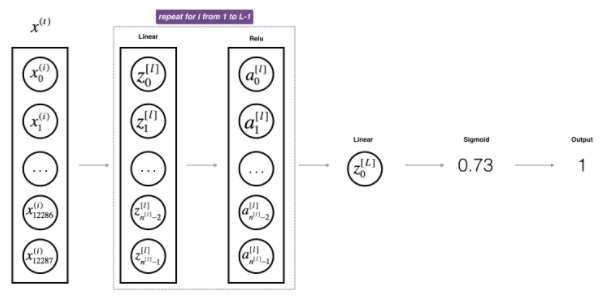

**提示**:
- 利用前面我们得出的函数 
- 用for循环调用 [LINEAR->RELU] (L-1) 次
- 别忘了每次都把 Z 加到 "caches" 列表中. 你可以使用 `list.append(c)` 把 `c` 加到一个列表 `list`中

In [7]:
# 多层模型前向传播

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, 
                                             parameters["W" + str(l)], 
                                             parameters["b" + str(l)], 
                                             activation='relu')
        caches.append(cache)

        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                             parameters["W" + str(L)], 
                                             parameters["b" + str(L)], 
                                             activation='sigmoid')
    caches.append(cache)
    
    # AL 表示 在 l 层的 A 向量
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

# 测试一下

def L_model_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    parameters = {'W1': np.array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ]]),
 'W2': np.array([[ 1.74481176, -0.7612069 ]]),
 'b1': np.array([[ 0.],
        [ 0.]]),
 'b2': np.array([[ 0.]])}
    """
    np.random.seed(1)
    X = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return X, parameters

X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
 
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[ 0.17007265  0.2524272 ]]
Length of caches list = 2


很好! 你现在拥有了一个完整的前向传播函数，输入 X 输出的行向量 $A^{[L]}$ 包含了预测值. 同时把中间值保存在了 "caches" 中. 使用 $A^{[L]}$, 我们可以计算预测的误差了.

**计算代价函数**

代价函数 $J$ 的公式如下: 

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [8]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1./ m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log( 1-AL)))
    # 简化后的数学公式，加速计算
    # cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

# 测试一下

def compute_cost_test_case():
    Y = np.asarray([[1, 1, 1]])
    aL = np.array([[.8,.9,0.4]])
    
    return Y, aL

Y, AL = compute_cost_test_case()
 
print("cost = " + str(compute_cost(AL, Y)))

cost = 0.414931599615


完成了前向传播，开始做反向传播，记住**反向传播是用来计算不通参数下的代价函数的梯度**

### 反向传播

神经网络传播结构图如下：

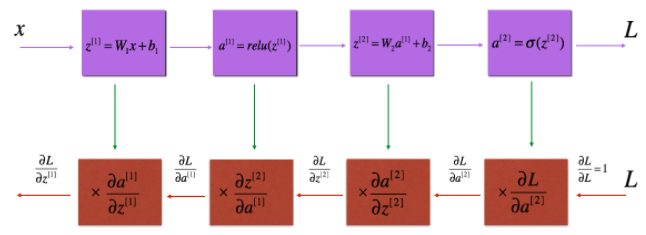

如果对微积分熟悉的话, 我们可以用微积分的链式法则来求 损失函数 $\mathcal{L}$ 在 $z^{[1]}$ 点导数，下面的公式列出了在 2 层神经网络中的求导:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

为了计算梯度 $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, 使用链式法则发现 $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. 在反向传播中, 每一次你用当前的梯度乘以对应层数的梯度来获取你想要的梯度.

同样的方法计算 $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$,  $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

这也是为什么我们称之为 **反向传播backpropagation**.


我们需要做单件事情:

- LINEAR 反向传播
- LINEAR -> ACTIVATION 反向传播 其中 ACTIVATION 计算对应 ReLU 或 sigmoid 激活函数的梯度
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID 反向传播 (完成整个模型)

### 线性部分

对于线性的部分，反向传播的公式如下：

对于层 $l$, 线性部分公式: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ .

假设已经获得导数 $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. 如果要获取 $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

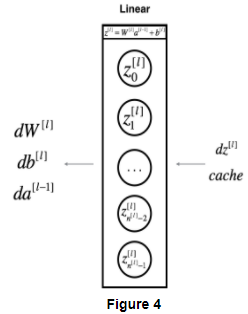


用  $dZ^{[l]}$ 来计算三个输出 $(dW^{[l]}, db^{[l]}, dA^{[l]})$ .公式如下:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [9]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)
 
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
 
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
     
    dW = 1./m * np.dot(dZ,A_prev.T)
    # dW = np.dot(dZ, A_prev.T) / m
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    # db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

# 测试一下

def linear_backward_test_case():
    """
    z, linear_cache = (np.array([[-0.8019545 ,  3.85763489]]), (np.array([[-1.02387576,  1.12397796],
       [-1.62328545,  0.64667545],
       [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), np.array([[1]]))
    """
    np.random.seed(1)
    dZ = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    linear_cache = (A, W, b)
    return dZ, linear_cache

dZ, linear_cache = linear_backward_test_case()
 
dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[ 0.50629448]]


### Linear-Activation部分

接下来我们创建线性激活的求导函数**`linear_activation_backward`**: 这里用到了上面的**`linear_backward`**函数 . 

为了简化 `linear_activation_backward`, 我们已经完成对对应激活函数的反向传播函数:

- **`sigmoid_backward`**: 实现了sigmoid单元的反向传播，调用如下:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: 实现了ReLU单元的反向传播，调用如下:

```python
dZ = relu_backward(dA, activation_cache)
```

假设 $g(.)$ 代表激活函数, `sigmoid_backward` 和 `relu_backward` 用来计算我们需要的结果 $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

In [10]:
# 计算激活函数的反向传播函数

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

# 测试一下

def linear_activation_backward_test_case():
    """
    aL, linear_activation_cache = (np.array([[ 3.1980455 ,  7.85763489]]), ((np.array([[-1.02387576,  1.12397796], [-1.62328545,  0.64667545], [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), 5), np.array([[ 3.1980455 ,  7.85763489]])))
    """
    np.random.seed(2)
    dA = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    Z = np.random.randn(1,2)
    linear_cache = (A, W, b)
    activation_cache = Z
    linear_activation_cache = (linear_cache, activation_cache)
    
    return dA, linear_activation_cache

AL, linear_activation_cache = linear_activation_backward_test_case()
 
dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")
 
dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


###  L层模型反向传播

我们要为整个网络实现反向传播. 回忆一下之前的实现 `L_model_forward` , 每一次迭代, 我们用cache缓存了 (X,W,b, 和 z). 在反向传播中, 我们将使用这些变量来计算梯度. 因此, 在 `L_model_backward` 中, 将遍历所有隐藏层, 从 $L$ 层开始. 每一次, 都是用当前层 $l$ 的cache来实现当前层 $l$ 的反向传播. 下图展示了过程. 

对于L层神经网络，其反向传播函数如下：

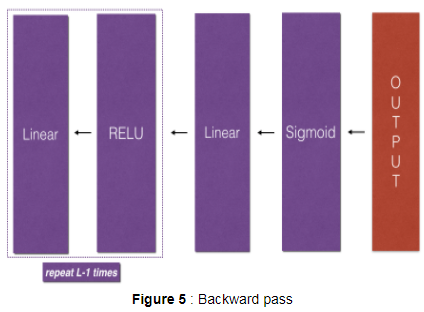

**初始化反向传播**:

对整个网络反向传播时, 首先我们知道输出, 
$A^{[L]} = \sigma(Z^{[L]})$. 我们的代码需要计算 `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
在此我们可以使用公式:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

然后我们可以使用首个传递过来的激活函数的梯度 `dAL` 来继续反向传播. 上图可知, 我们可以把 `dAL` 传给我们上面已经实现的 LINEAR->SIGMOID 反向传播函数 . 之后, 我们要使用 `for` 循环 所有其他使用 LINEAR->RELU 的层做反向传播. 别忘了把结果 dA, dW, and db 在一个 grads 字典里. 公式如下 : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

比如, 对于 $l=3$ 会缓存 $dW^{[l]}$ 在 `grads["dW3"]` 里.


In [11]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# 测试一下

def L_model_backward_test_case():
    """
    X = np.random.rand(3,2)
    Y = np.array([[1, 1]])
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747]]), 'b1': np.array([[ 0.]])}
    aL, caches = (np.array([[ 0.60298372,  0.87182628]]), [((np.array([[ 0.20445225,  0.87811744],
           [ 0.02738759,  0.67046751],
           [ 0.4173048 ,  0.55868983]]),
    np.array([[ 1.78862847,  0.43650985,  0.09649747]]),
    np.array([[ 0.]])),
   np.array([[ 0.41791293,  1.91720367]]))])
   """
    np.random.seed(3)
    AL = np.random.randn(1, 2)
    Y = np.array([[1, 0]])

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1)

    A2 = np.random.randn(3,2)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    Z2 = np.random.randn(1,2)
    linear_cache_activation_2 = ( (A2, W2, b2), Z2)

    caches = (linear_cache_activation_1, linear_cache_activation_2)

    return AL, Y, caches

AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


### 更新参数

参数更新公式如下：

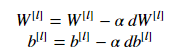

In [12]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
        
    return parameters

# 测试一下

def update_parameters_test_case():
    """
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747],
        [-1.8634927 , -0.2773882 , -0.35475898],
        [-0.08274148, -0.62700068, -0.04381817],
        [-0.47721803, -1.31386475,  0.88462238]]),
 'W2': np.array([[ 0.88131804,  1.70957306,  0.05003364, -0.40467741],
        [-0.54535995, -1.54647732,  0.98236743, -1.10106763],
        [-1.18504653, -0.2056499 ,  1.48614836,  0.23671627]]),
 'W3': np.array([[-1.02378514, -0.7129932 ,  0.62524497],
        [-0.16051336, -0.76883635, -0.23003072]]),
 'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
 'b2': np.array([[ 0.],
        [ 0.],
        [ 0.]]),
 'b3': np.array([[ 0.],
        [ 0.]])}
    grads = {'dW1': np.array([[ 0.63070583,  0.66482653,  0.18308507],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 'dW2': np.array([[ 1.62934255,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 'dW3': np.array([[-1.40260776,  0.        ,  0.        ]]),
 'da1': np.array([[ 0.70760786,  0.65063504],
        [ 0.17268975,  0.15878569],
        [ 0.03817582,  0.03510211]]),
 'da2': np.array([[ 0.39561478,  0.36376198],
        [ 0.7674101 ,  0.70562233],
        [ 0.0224596 ,  0.02065127],
        [-0.18165561, -0.16702967]]),
 'da3': np.array([[ 0.44888991,  0.41274769],
        [ 0.31261975,  0.28744927],
        [-0.27414557, -0.25207283]]),
 'db1': 0.75937676204411464,
 'db2': 0.86163759922811056,
 'db3': -0.84161956022334572}
    """
    np.random.seed(2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    np.random.seed(3)
    dW1 = np.random.randn(3,4)
    db1 = np.random.randn(3,1)
    dW2 = np.random.randn(1,3)
    db2 = np.random.randn(1,1)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return parameters, grads

parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)
 
print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


至此为止，我们已经实现该神经网络中，所有需要的函数。

接下来，我们将这些方法组合在一起，构成一个神经网络类，可以方便的使用。



### 两层神经网络模型

一个两层的神经网络模型图如下：

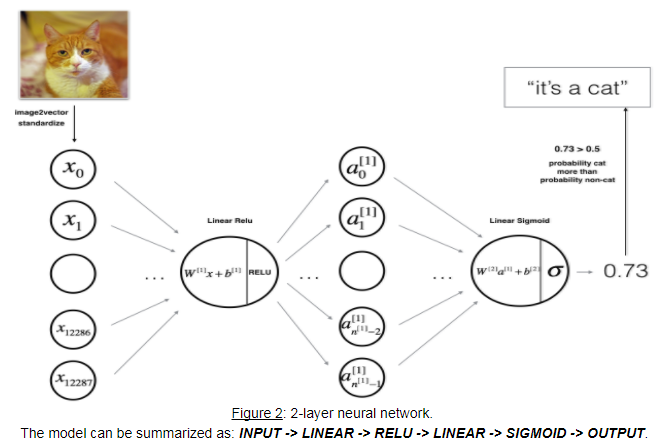

<u>图解</u>:
- 输入源是 (64,64,3) 图片向量，并flatten为 $(12288,1)$ 的向量. 
- 向量: $[x_0,x_1,...,x_{12287}]^T$ 乘以维度是 $(n^{[1]}, 12288)$ 的权重矩阵 $W^{[1]}$  .
- 加上bias，传给 relu 得到 向量: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- 重复相同的步骤.
- 对结果向量乘以权重 $W^{[2]}$ 并加上intercept (bias). 
- 最后获得sigmoid结果. 大于 0.5, 判断为猫.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213017
Cost after iteration 1300: 0.24681768210614838
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.17080762978095967
Cost after iteration 1700: 0.11306524562164735
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726858
Cost after iteration 2000: 0.0743907870431908
Cost after iteration 2100: 0.06630748132

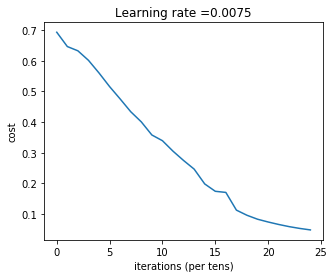

In [13]:
# 定义常量

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

# 两层网络模型

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
 
    for i in range(0, num_iterations):
 
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
 
        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
 
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# 训练一下

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnocat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnocat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

parameters = two_layer_model(train_set_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [14]:
# 看看我们的预测准确度吧

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

predictions_train = predict(train_set_x, train_set_y, parameters)

predictions_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 1.0
Accuracy: 0.72


**Note**: 你可能会发现如果使用较少的迭代次数 (比如 1500) 在测试集会获得更好的精度. 这被称为 "early stopping". Early stopping 可以用来避免 overfitting.

### 多层神经网络

一个多层的神经网络模型如下：

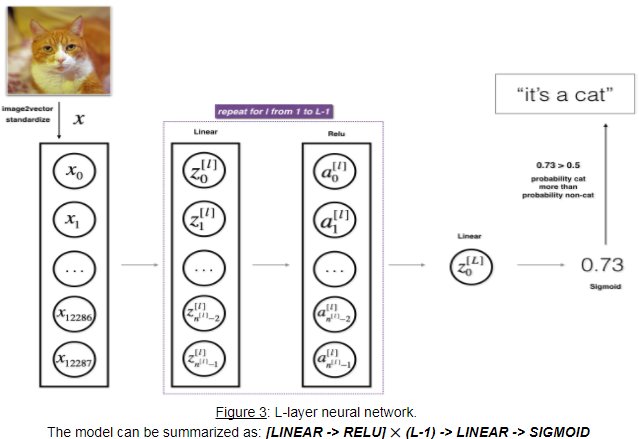

<u>图解</u>:
- 输入源 (64,64,3) 的图片向量 并flatten为 (12288,1).
- 向量: $[x_0,x_1,...,x_{12287}]^T$ 乘以权重矩阵 $W^{[1]}$ 并加上 $b^{[1]}$. 我们称这一步的结果为线性单元 the linear unit.
- 接着, 获得线性单元的 relu值. 根据模型结构对每个 $(W^{[l]}, b^{[l]})$ 重复这个过程
- 最后获得最后一个线性单元的sigmoid值. 大于 0.5, 认为是猫.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


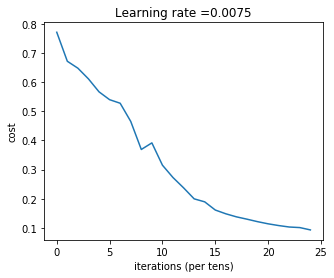

In [15]:
# 初始化常量

layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

# L层神经网络模型：

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# 测试一下

parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)



In [16]:
# 查看一下精确度

pred_train = predict(train_set_x, train_set_y, parameters)

pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.985645933014
Accuracy: 0.8


之后我们会讲解如何为何获得更高的精度 通过系统化的找寻更好的 hyperparameters (learning_rate, layers_dims, num_iterations, 等等).

### 结果分析：

接下来，让我们对分类错误的图像进行一下结果分析吧：

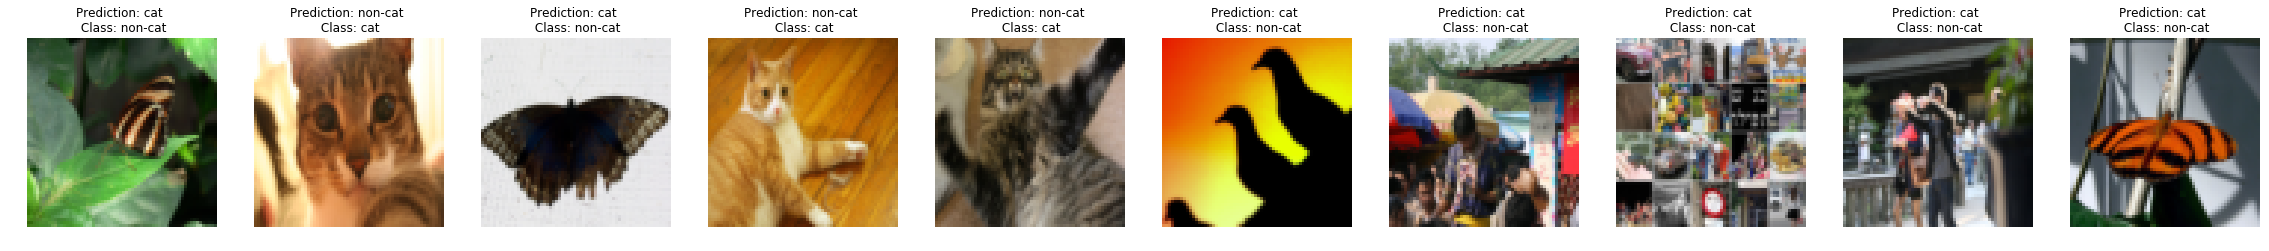

In [17]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))
        
print_mislabeled_images(classes, test_set_x, test_set_y, pred_test)  #显示所有分类错误的图片


**似乎模型对某些图片的识别率很差:** 
- 猫处在一个奇怪的姿势
- 猫的颜色和背景很相似
- 很特别的猫品种或者毛色
- 拍摄角度
- 图片亮度
- 放大缩小，图中猫要么很大要么很小 

## 用自己的图片试试吧：


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


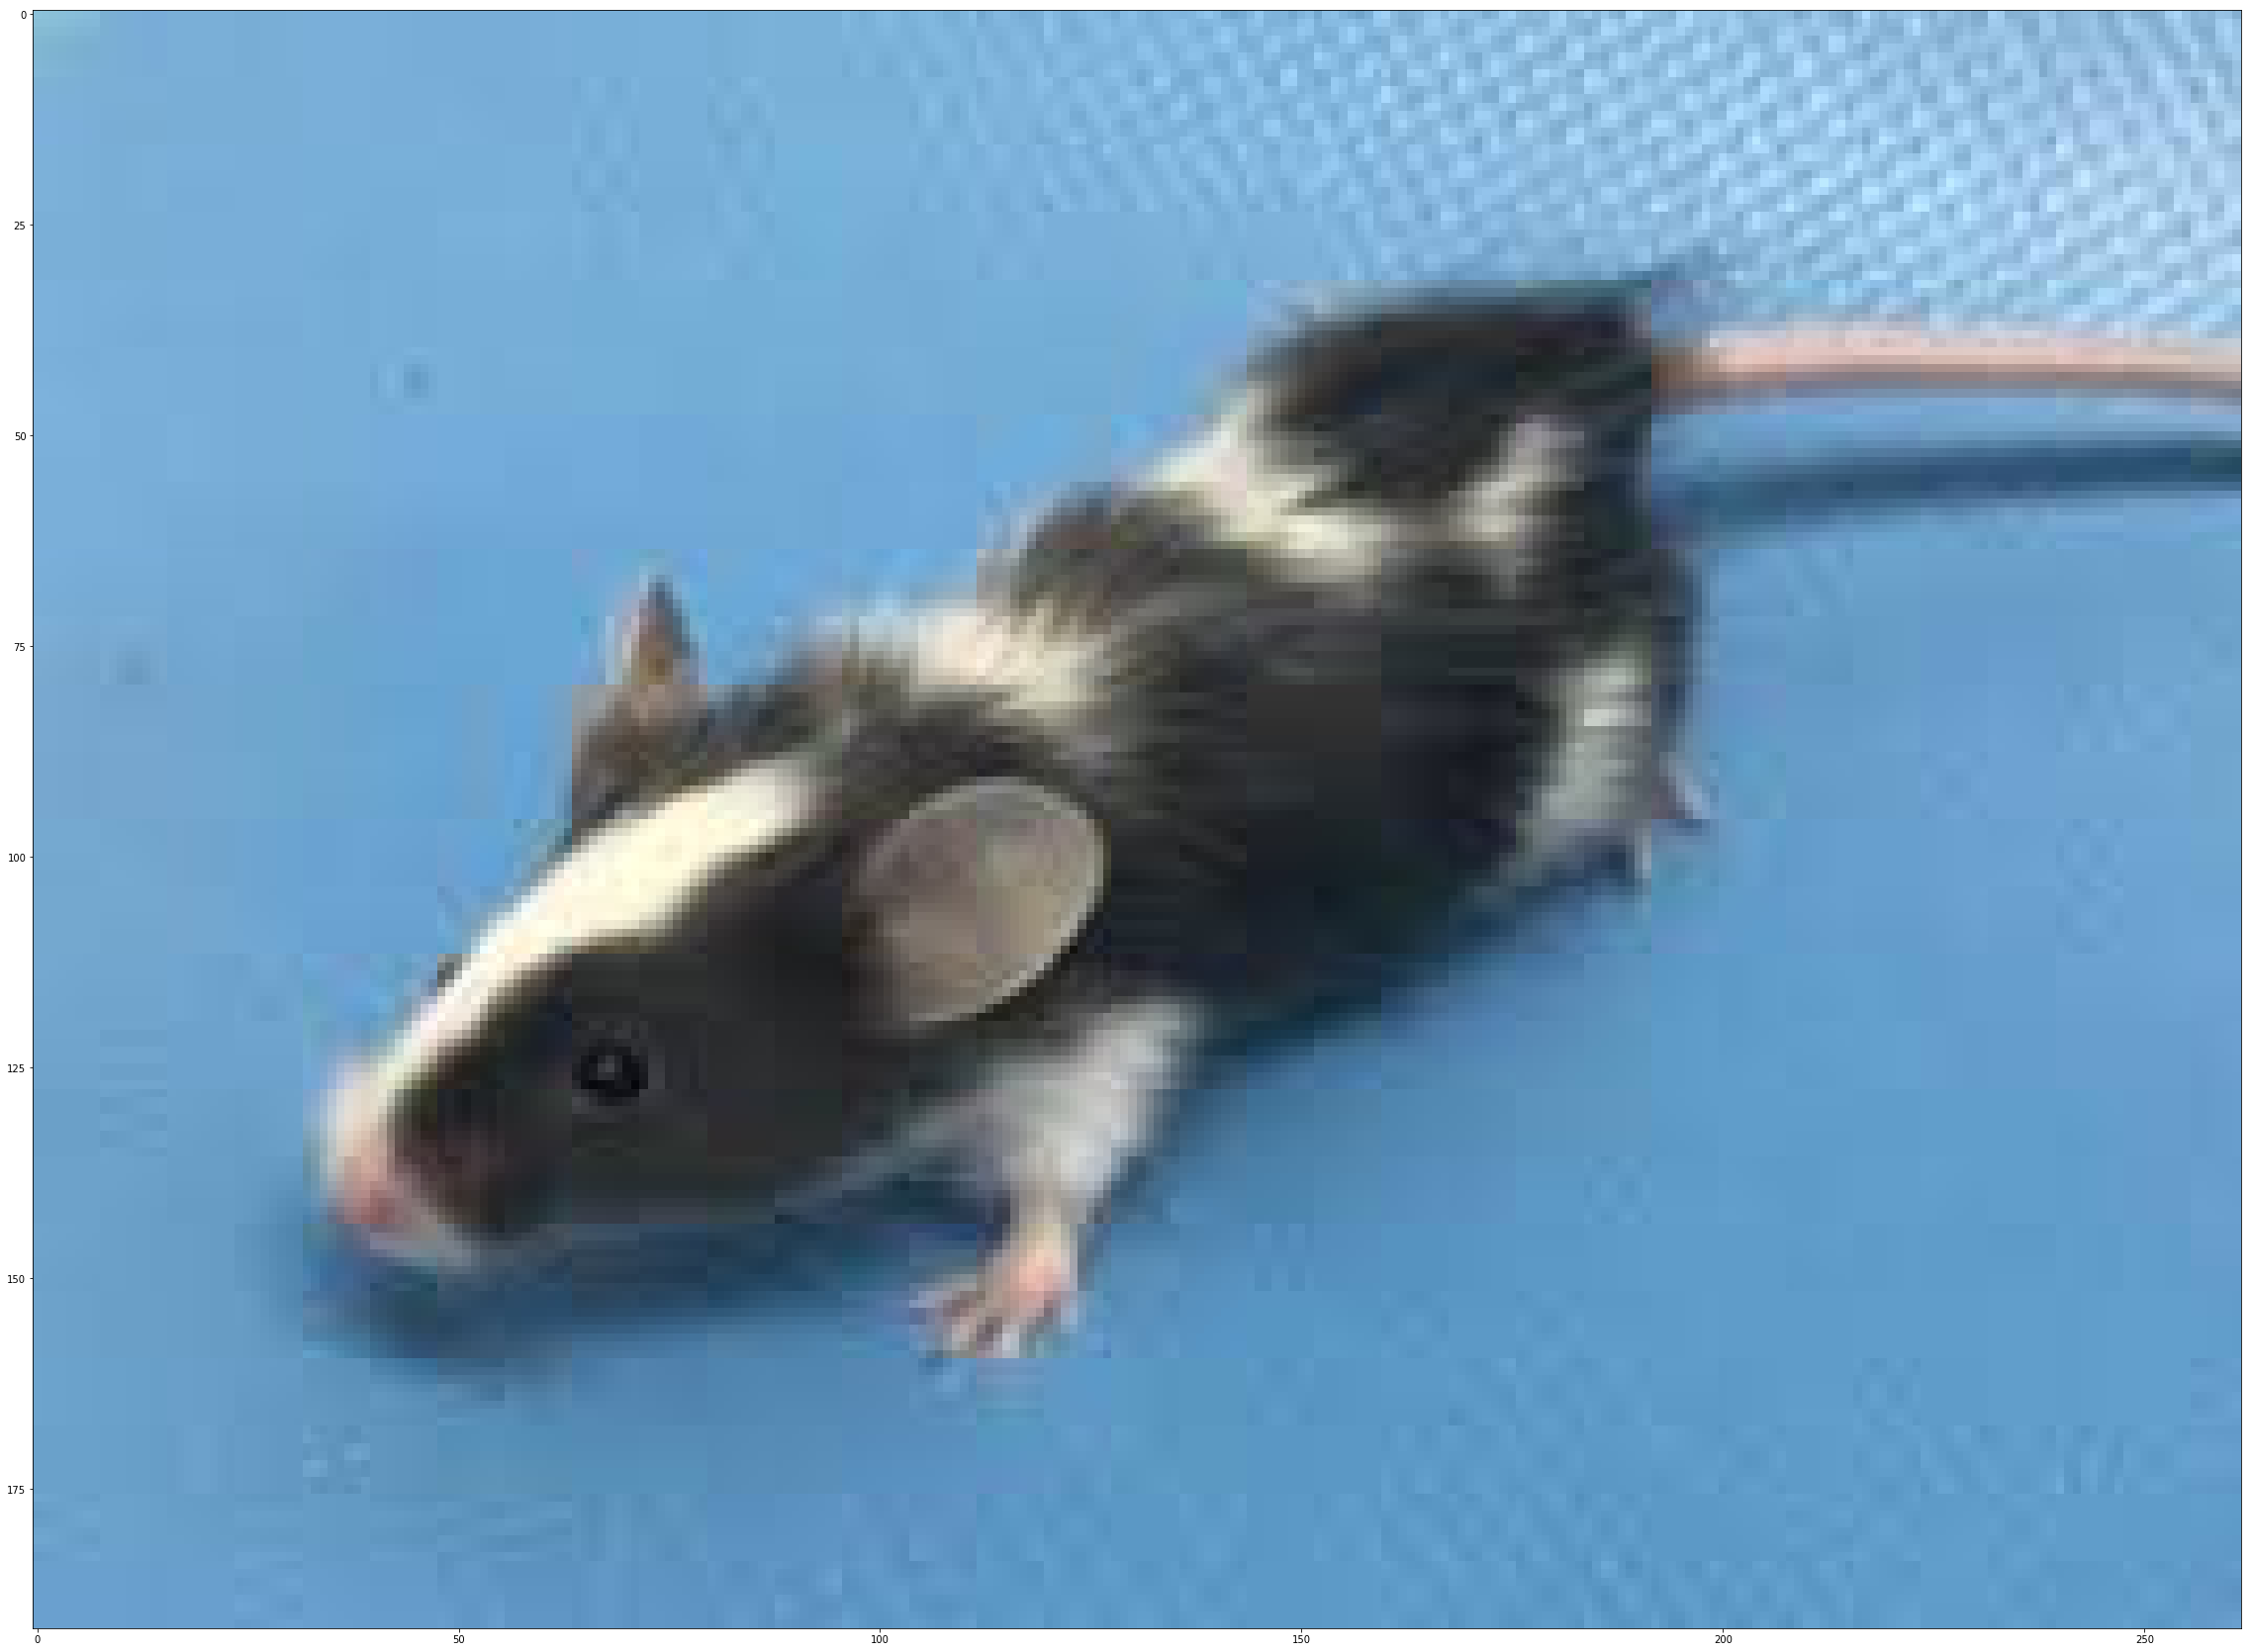

In [29]:
## START CODE HERE ##
my_image = "animal_4.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##
 
fname = "test_image/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((64*64*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)
 
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

### 最后我们总结一下整个开发步骤

1. Initialize parameters / Define hyperparameters

2. Loop for num_iterations

   2.1 Forward propagation
   
   2.2 Compute cost function
   
   2.3 Backward propagation
   
   2.4 Update parameters (using parameters, and grads from backprop)
   
4. Use trained parameters to predict labels